# Generating the Growth Graph of the Most Massive Galaxies

In this document, we'll navigate the IllustrisTNG Project Database to identify the most massive galaxies in  the TNG100-1 simulation and generate the Growth Graphs.

As shown in the document **Data Structure of IllustrisTNG Database**, the .png file of the merger tree is available. Let's navigate there. 

First, load all the required packages and important data:

In [1]:
import requests                 # To use the helper function "get"
import h5py                     # To read .hdf5 files in Python
import matplotlib.pyplot as mpl # To plot using the data from .hdf5 fiels
from skimage import io          # To work with images
import numpy as np              # To calculate big numerical data
import cv2                      # To create the video
import os                       # To navigate working directories
import copy

baseUrl = 'http://www.tng-project.org/api/'               # URL to the API Root
headers = {"api-key":"your_key_here"}                     # API Key required to access the database
                                                          # Make sure to change this!

We also need the helper function we used in the other document to naviage the API:

In [2]:
def get(path, params=None): # This is provided by the IllustrisTNG Project
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

Since all the details on the navigation and data structure are already explained in the other document, we'll navigate straight to our point of interest, *Subhalo List* page at $z=0$.

In [3]:
root = get(baseUrl)                                   # Getting to API Root
names = [sim['name'] for sim in root['simulations']]  # Creating list of simulations
i = names.index('TNG100-1')                           # Finding where 'TNG100-1' is stored in the list
sim = get(root['simulations'][i]['url'])              # Navigating to Simulation Details page
snaps = get(sim['snapshots'])                         # Navigating to Snapshot List page
snap = get(snaps[-1]['url'])                          # Naviagting to Snapshot Details page for z=0
subs = get(snap['subhalos'],                          
           {'limit':20, 'order_by':'-mass_stars'})    # Navigating to Subhalo List page for z=0,
                                                      #     ordered in decreasing mass. 

Let's get a listing of the top 5 subhalos, in order of decreasing mass.

In [4]:
ids = [subs['results'][i]['id'] for i in range(5) ]
ids

[0, 31342, 17185, 69507, 83280]

To make the organization easier, let's create a directory for these subhalo IDs.

In [5]:
parent_dir = '/Users/hwoo1211/Jupyter Notebook/Growth Graph/' # This is for Mac
#parent_dir = 'D:\Jupyter Notebook\Growth Graph/'             # This is for Windows

for id in ids:
    path = os.path.join(parent_dir, str(id))
    os.mkdir(path)

Then, change the working directory to the first folder:

In [6]:
img_dir = parent_dir + '/' + str(ids[0])
os.chdir(img_dir)
os.getcwd()

'/Users/hwoo1211/Jupyter Notebook/Growth Graph/0'

Now let's get the details on this specific subhalo:

In [7]:
sub = get(subs['results'][0]['url'])

And let's define couple more arrays...

In [8]:
zvalues = []
fields = ['snap', 'id', 'sfr', 'mass_gas', 'mass_stars', 'mass_dm', 'mass_bhs']
r = {}
for field in fields:
    r[field] = []
r

{'snap': [],
 'id': [],
 'sfr': [],
 'mass_gas': [],
 'mass_stars': [],
 'mass_dm': [],
 'mass_bhs': []}

And let's fill in the information for each field, by traveling the link provided by sublink progenitor key, like so:

In [9]:
while True:
    for field in fields:
        r[field].append(sub[field])
    snapshot = get(sub['meta']['snapshot'])
    zvalues.append(snapshot['redshift'])
    if(sub['prog_sfid'] == -1):
        break
    sub = get(sub['related']['sublink_progenitor'])

And add the new key-value set to the original dictionary:

In [10]:
r.update({"zvalues" : zvalues})

Now, let's define a function that will pick out the "dips" in the graph, i.e., the outlier values that will create a dip in the graph. 

In [11]:
def findDips(dataList, positionList):
    masses = ['mass_gas', 'mass_stars', 'mass_dm', 'mass_bhs']
    for mass in masses:
        for i in range(len(dataList[mass]) - 1):
            if(i == 0):
                continue
            elif(mass == 'mass_bhs'):
                if(((dataList[mass][i] - dataList[mass][i+1]) > 0.3) and 
                    (positionList.count(dataList['snap'][i]) == 0)):
                    positionList.append(dataList['snap'][i + 1])
            elif(((dataList[mass][i + 1] - dataList[mass][i]) > 10) and 
                    (positionList.count(dataList['snap'][i]) == 0)):
                positionList.append(dataList['snap'][i])

And finally, let's define the subroutine to delete those outliers:

In [12]:
position_list = []
key = ['snap', 'id', 'sfr', 'mass_gas', 'mass_stars', 'mass_dm', 'mass_bhs', 'zvalues']
while True:
    position_list = []
    index_list = []
    findDips(r, position_list)
    
    i = 0
    for j in position_list:
        i = r['snap'].index(j)
        for keys in key:
           r[keys].pop(i)
    if(len(position_list) == 0):
        break

Now, we are ready to graph. First, let's graph the four masses arragned by Snapshot Number:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


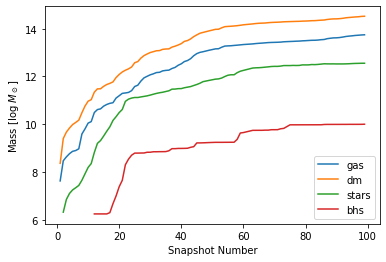

In [13]:
for partType in ['gas', 'dm', 'stars', 'bhs']:
    mass_logmsun = np.log10(np.array(r['mass_'+partType])*1e10/0.704)
    mpl.plot(r['snap'], mass_logmsun, label=partType)
    
mpl.xlabel('Snapshot Number')
mpl.ylabel('Mass [log $M_\odot$]')
mpl.legend(loc='lower right');


mpl.savefig(('Masses_' + str(ids[0])+'_snapnum'),bbox_inches='tight')
mpl.show()
mpl.close()

Then, let's graph the same values using redshifts: 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


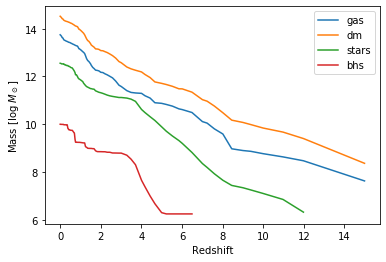

In [14]:
for partType in ['gas', 'dm', 'stars', 'bhs']:
    mass_logmsun = np.log10(np.array(r['mass_'+partType])*1e10/0.704)
    mpl.plot(r['zvalues'], mass_logmsun, label=partType)
    
mpl.xlabel('Redshift')
mpl.ylabel('Mass [log $M_\odot$]')
mpl.legend(loc='upper right');


mpl.savefig(('Masses_' + str(ids[0])+'_znum'),bbox_inches='tight')
mpl.show()
mpl.close()

Then, let's plot the dark matter mass and masses of stars, along with the star formation rate. 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


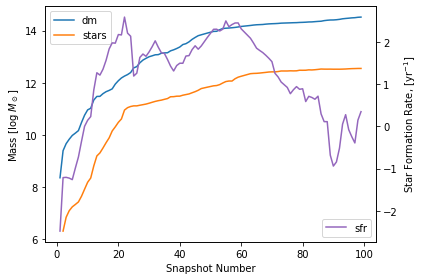

In [15]:
mpl.close()
fig, ax1 = mpl.subplots()
ax1.set_xlabel('Snapshot Number')
ax1.set_ylabel('Mass [log $M_\odot$]')
#for partType in ['gas', 'dm', 'stars', 'bhs']:
for partType in ['dm', 'stars']:
    mass_logmsun = np.log10(np.array(r['mass_'+partType])*1e10/0.704)
    ax1.plot(r['snap'], mass_logmsun, label=partType)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Star Formation Rate, [yr$^{-1}$]')

sfr = np.log10(np.array(r['sfr']))

ax2.plot(r['snap'], sfr, label='sfr', color = 'tab:purple')
ax2.tick_params(axis='y')

fig.tight_layout()
ax1.legend(loc='upper left');
ax2.legend(loc='lower right');

mpl.savefig(('Masses_' + str(ids[0])+'_withsfr_snapnum'),bbox_inches='tight')
mpl.show()
mpl.close()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


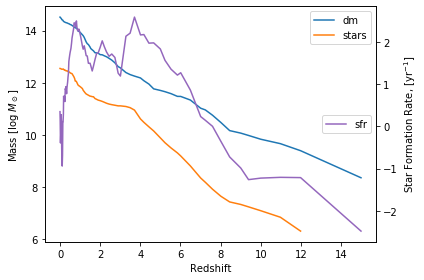

In [16]:
mpl.close()
fig, ax1 = mpl.subplots()
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Mass [log $M_\odot$]')
#for partType in ['gas', 'dm', 'stars', 'bhs']:
for partType in ['dm', 'stars']:
    mass_logmsun = np.log10(np.array(r['mass_'+partType])*1e10/0.704)
    ax1.plot(r['zvalues'], mass_logmsun, label=partType)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Star Formation Rate, [yr$^{-1}$]')

sfr = np.log10(np.array(r['sfr']))

ax2.plot(r['zvalues'], sfr, label='sfr', color = 'tab:purple')
ax2.tick_params(axis='y')

fig.tight_layout()
ax1.legend(loc='upper right');
ax2.legend(loc='right');

mpl.savefig(('Masses_' + str(ids[0])+'_withsfr_znum'),bbox_inches='tight')
mpl.show()
mpl.close()

Now let's repeat this for the other five massive galaxies.

In [ ]:
for i in range(4):
    img_dir = parent_dir + '/' + str(ids[i+1])
    os.chdir(img_dir)

    sub = get(subs['results'][i+1]['url'])

    r.clear()
    zvalues = []
    fields = ['snap', 'id', 'sfr', 'mass_gas', 'mass_stars', 'mass_dm', 'mass_bhs']
    r = {}
    for field in fields:
        r[field] = []
    while True:
        for field in fields:
            r[field].append(sub[field])
        snapshot = get(sub['meta']['snapshot'])
        zvalues.append(snapshot['redshift'])
        if(sub['prog_sfid'] == -1):
            break
        sub = get(sub['related']['sublink_progenitor'])

    r.update({"zvalues" : zvalues})

    position_list = []
    index_list = []
    key = ['snap', 'id', 'sfr', 'mass_gas', 'mass_stars', 'mass_dm', 'mass_bhs', 'zvalues']
    while True:
        position_list = []
        index_list = []
        findDips(r, position_list)

        k = 0
        for j in position_list:
            k = r['snap'].index(j)
            for keys in key:
               r[keys].pop(k)
        if(len(position_list) == 0):
            break

    # Masses by Snapshot Number
    for partType in ['gas', 'dm', 'stars', 'bhs']:
        mass_logmsun = np.log10(np.array(r['mass_'+partType])*1e10/0.704)
        mpl.plot(r['snap'], mass_logmsun, label=partType)
    
    mpl.xlabel('Snapshot Number')
    mpl.ylabel('Mass [log $M_\odot$]')
    mpl.legend(loc='lower right');


    mpl.savefig(('Masses_' + str(ids[i+1])+'_snapnum'),bbox_inches='tight')
    mpl.show()
    mpl.close()
    
    # Masses by Redshift
    for partType in ['gas', 'dm', 'stars', 'bhs']:
        mass_logmsun = np.log10(np.array(r['mass_'+partType])*1e10/0.704)
        mpl.plot(r['zvalues'], mass_logmsun, label=partType)

    mpl.xlabel('Redshift')
    mpl.ylabel('Mass [log $M_\odot$]')
    mpl.legend(loc='upper right');


    mpl.savefig(('Masses_' + str(ids[i+1])+'_znum'),bbox_inches='tight')
    mpl.show()
    mpl.close()
    
    # Masses + sfr by Snapshot Number
    
    mpl.close()
    fig, ax1 = mpl.subplots()
    ax1.set_xlabel('Snapshot Number')
    ax1.set_ylabel('Mass [log $M_\odot$]')
    #for partType in ['gas', 'dm', 'stars', 'bhs']:
    for partType in ['dm', 'stars']:
        mass_logmsun = np.log10(np.array(r['mass_'+partType])*1e10/0.704)
        ax1.plot(r['snap'], mass_logmsun, label=partType)
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Star Formation Rate, [yr$^{-1}$]')

    sfr = np.log10(np.array(r['sfr']))

    ax2.plot(r['snap'], sfr, label='sfr', color = 'tab:purple')
    ax2.tick_params(axis='y')

    fig.tight_layout()
    ax1.legend(loc='upper left');
    ax2.legend(loc='lower right');

    mpl.savefig(('Masses_' + str(ids[i+1])+'_withsfr_snapnum'),bbox_inches='tight')
    mpl.show()
    mpl.close()
    
    # Masses + sfr by Redshift
    
    mpl.close()
    fig, ax1 = mpl.subplots()
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel('Mass [log $M_\odot$]')
    #for partType in ['gas', 'dm', 'stars', 'bhs']:
    for partType in ['dm', 'stars']:
        mass_logmsun = np.log10(np.array(r['mass_'+partType])*1e10/0.704)
        ax1.plot(r['zvalues'], mass_logmsun, label=partType)
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Star Formation Rate, [yr$^{-1}$]')

    sfr = np.log10(np.array(r['sfr']))

    ax2.plot(r['zvalues'], sfr, label='sfr', color = 'tab:purple')
    ax2.tick_params(axis='y')

    fig.tight_layout()
    ax1.legend(loc='upper right');
    ax2.legend(loc='right');

    mpl.savefig(('Masses_' + str(ids[i+1])+'_withsfr_znum'),bbox_inches='tight')
    mpl.show()
    mpl.close()